Import the important packages/library to be used

In [555]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

Importing the data (DSX code)

In [556]:
# The code was removed by DSX for sharing.

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


Compute simple statistics around the data (especially for the different sources, countries and price plan

In [614]:
user_count = len(df_data_1.user_id.unique())
print("there are " + str(user_count) + " subscribers at the start")

there are 500000 subscribers at the start


In [618]:
print(df_data_1.groupby(['subscription_monthly_cost']).size())

subscription_monthly_cost
29    146362
49    300397
99     53241
dtype: int64


In [619]:
print(df_data_1.groupby(['country']).size())

country
China      35938
France     51662
Germany    88944
India      48027
Italy      47459
Spain      44987
UK         91252
US         91731
dtype: int64


In [620]:
print(df_data_1.groupby(['source']).size())

source
ads                414469
friend_referral     24428
seo                 61103
dtype: int64


After we look at the individual variables, we would like to know if there is any interesting interactions between variables. Things we found for example is that China and India have significantly more subscribers with price plan 29

In [626]:
# here we pick country and subscription monthly cost but we did it for all the combinations

user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country']).size()}).reset_index()
user_count_high = pd.DataFrame({'user_count_high' : df_data_1.groupby(['country']).size()}).reset_index()
df_proportion_country = pd.merge(user_count_high, user_count, how='inner', on=['country'])
df_proportion_country['user_count_prop'] = df_proportion_country['user_count']/df_proportion_country['user_count_high']
df_proportion_country

,country,user_count_high,subscription_monthly_cost,user_count,user_count_prop
0,China,35938,29,16741,0.465830
1,China,35938,49,18541,0.515916
2,China,35938,99,656,0.018254
3,France,51662,29,14249,0.275812
4,France,51662,49,31074,0.601487
5,France,51662,99,6339,0.122701
6,Germany,88944,29,21794,0.245031
7,Germany,88944,49,55500,0.623988
8,Germany,88944,99,11650,0.130981
9,India,48027,29,16920,0.352302


Definition of additional KPI: number of subscribers that has left since start, number of subscribers still active at each month, churn rate, retention rate.
Eventually the KPI of most interest in the percentage of subscribers left since start

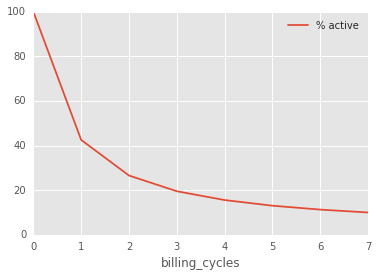

In [631]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( [ 'billing_cycles'] ).size()}).reset_index()
user_count = len(df_data_1.user_id.unique())

#number of subscribers that has left

df_data_overall['# churners'] = df_data_overall['count'].cumsum()

#number of subscribers still active

df_data_overall['# active'] = user_count - df_data_overall['# churners']

# Adding the month 0 to the dataframe

df_data_overall_0 = pd.DataFrame({'billing_cycles': [0],'# churners': [0],'# active': [user_count] , 'count' : [user_count]})

df_data_overall = df_data_overall_0.append(df_data_overall,ignore_index=True)

# number of active subscribers normalized (%)

df_data_overall['% active'] = df_data_overall['# active']/user_count*100

# churn rate 

df_data_overall['churn rate'] = df_data_overall['count']/df_data_overall['# active'].shift(1)

# retention rate

df_data_overall['retention rate'] = 1 - df_data_overall['churn rate']

df_data_overall.plot(x = 'billing_cycles',y = '% active')

#df_data_overall['retention rate'].plot()

On top of the % active users, we are interested to study how the revenue are distributed between price plans. Usually we observe that the 20% of the subscribers are generating 80% of the revenues (usually the highest revenue segment). It is known as the Pareto law. Here the results are different

In [633]:
df_sub = pd.DataFrame({'count' : df_data_1.groupby( ['billing_cycles','subscription_monthly_cost'] ).size()}).reset_index()
df_sub['revenue'] = df_sub['count']*df_sub['billing_cycles']*df_sub['subscription_monthly_cost']

pyramid = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
pyramid['revenue since start'] = df_sub.groupby(['subscription_monthly_cost']).sum().reset_index()['revenue']
pyramid['user count last month'] = df_sub.loc[lambda df: df.billing_cycles == 8].reset_index()['count']
pyramid['revenue last month'] = pyramid['user count last month']*pyramid['subscription_monthly_cost']

total = pyramid.sum()

pyramid['user_count %'] = pyramid['user_count'] / total['user_count'] 
pyramid['revenue since start %'] = pyramid['revenue since start'] / total['revenue since start']
pyramid['user count last month %'] = pyramid['user count last month']  / total['user count last month']
pyramid['revenue last month %'] = pyramid['revenue last month'] / total['revenue last month']


pyramid = pyramid.sort_values(['subscription_monthly_cost'],ascending=False)

pyramid_cum = pyramid.groupby('subscription_monthly_cost').sum().sort_index(ascending=False).cumsum().add_suffix('_cum').reset_index()

pyramid = pd.merge(pyramid,pyramid_cum,on='subscription_monthly_cost')
pyramid

,subscription_monthly_cost,user_count,revenue since start,user count last month,revenue last month,user_count %,revenue since start %,user count last month %,revenue last month %,user_count_cum,revenue since start_cum,user count last month_cum,revenue last month_cum,user_count %_cum,revenue since start %_cum,user count last month %_cum,revenue last month %_cum
0,99,53241,7147404,799,79101,0.106482,0.138333,0.015980,0.043961,53241.0,7147404.0,799.0,79101.0,0.106482,0.138333,0.015980,0.043961
1,49,300397,29479331,14673,718977,0.600794,0.570551,0.293466,0.399574,353638.0,36626735.0,15472.0,798078.0,0.707276,0.708884,0.309446,0.443534
2,29,146362,15041430,34527,1001283,0.292724,0.291116,0.690554,0.556466,500000.0,51668165.0,49999.0,1799361.0,1.000000,1.000000,1.000000,1.000000


What exactly are we predicting? we are predicting the monthly retention rate (i.e. how many subscribers did you keep / number of subscribers still there last month).
We compute the KPIs for all the subscription monthly cost (same computation as above except that it is done for each cost)

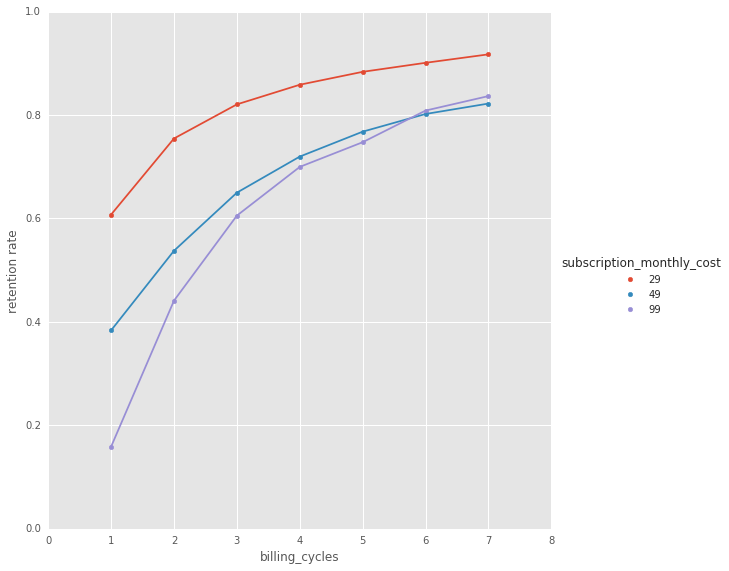

In [651]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['subscription_monthly_cost','billing_cycles'] ).size()}).reset_index()

df = df_data_overall.groupby(['subscription_monthly_cost','billing_cycles'] ).sum().groupby(level=[0]).cumsum()
df = df.add_suffix('_cumsum').reset_index()
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
df = pd.merge(df, user_count, how='inner', on='subscription_monthly_cost')

df = df.rename(columns={"count_cumsum": "# churners"})

df['# active'] = df['user_count'] - df['# churners']

# Adding the month 0 to the dataframe

df_0 = pd.DataFrame({'billing_cycles': [0,0,0],'# churners': [0,0,0],'subscription_monthly_cost' : user_count['subscription_monthly_cost'],'# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

df = df_0.append(df,ignore_index=True)

# number of active subscribers normalized (%)

df['% active'] = df['# active']/df['user_count']*100

# churn rate 

df = df.sort_values(['subscription_monthly_cost','billing_cycles'])

df['churn rate'] = (df['# churners']-df['# churners'].shift(1))/df['# active'].shift(1)

# retention rate

df['retention rate'] = 1 - df['churn rate']

df = df.join(pd.get_dummies(df['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))


#Bayesian prior -- I'll explain later
df_end = pd.DataFrame({'billing_cycles': [100,100,100],'retention rate' :[1,1,1],'subscription_monthly_cost':[29,49,99],'subscription_monthly_cost_29':[1,0,0],'subscription_monthly_cost_49':[0,1,0],'subscription_monthly_cost_99':[0,0,1]})
    
g = sns.FacetGrid(df.loc[lambda df: df.billing_cycles != 0], hue='subscription_monthly_cost', size=8,xlim = [0,8],ylim = [0,1])
g.map(plt.scatter, "billing_cycles", "retention rate")
g.map(plt.plot, "billing_cycles", "retention rate").add_legend()


plt.show()

Time to run the first models - Our first choice goes to the shifted Beta Geometric distribution that has shown very interesting results for retention predictions (Hardie)

In [653]:
#the feature are the one-hot encoding of the costs
feature_list = ['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99']

data = df_data_1[['is_active','billing_cycles','subscription_monthly_cost']].join(pd.get_dummies(df_data_1['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))

# Make the cost a string and a category
data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')

#separate training and testing data
train, test = train_test_split(data, test_size = 0.2)

# define the model with a gamma (~learning rate) low
sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=feature_list,gamma=1e-3,verbose=True)

# Train model
sbs.fit(data)

# Summary of results
print(sbs.summary())

Starting Optimization with parameters:
        Samples: 500000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:45   |  656516.10486 |

Optimization completed:
             wa: [ 0.20775507 -0.25482746  0.1654169   0.08460263]
             wb: [-0.1327831   0.09032018  0.08620505 -0.33155588]
  LogLikelihood: 656516.1048560628
   Reg. Penalty: 0.00022497573863886254

                               w_alpha    w_beta
bias                          0.207755 -0.132783
subscription_monthly_cost_29 -0.254827  0.090320
subscription_monthly_cost_49  0.165417  0.086205
subscription_monthly_cost_99  0.084603 -0.331556


Now that we have a model we want to compare its results with the actual values first visually and then analytically (accuracy)

[ 0.15831367  0.45921215  0.60162805  0.6846699   0.73906301  0.77745166
  0.80599358]
[ 0.15831367  0.45921215  0.60162805  0.6846699   0.73906301  0.77745166
  0.80599358]
[ 0.15831367  0.45921215  0.60162805  0.6846699   0.73906301  0.77745166
  0.80599358]


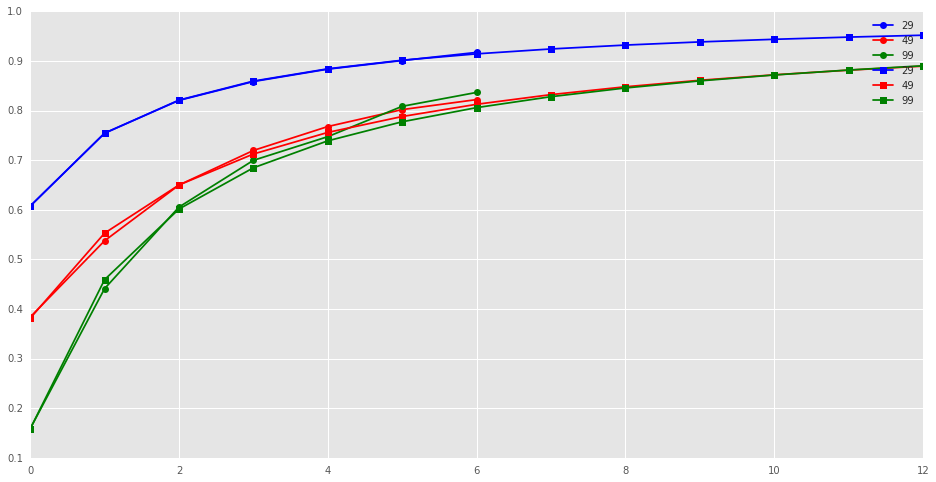

In [658]:
pred_train = train.reset_index().join([sbs.predict_churn(train, age=1, n_periods=13)])
pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])

f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {'29': 'b', '49': 'r', '99': 'g'}

df['subscription_monthly_cost'] = df['subscription_monthly_cost'].apply(str).astype('category')

for name in ['29','49','99']:
    axis.plot(df.loc[lambda df: (df.subscription_monthly_cost==name)]['retention rate'].values[1:8], alpha=1, c=col_map[name], label=name,marker='o')
    #print(1-df.loc[lambda df: (df.subscription_monthly_cost==name)]['retention rate'].values[1:8])



# we do not plot the training data    
for name, df1 in pred_train.groupby('subscription_monthly_cost'):
  #  print((df1.mean().values[7:]/(1-np.roll(np.cumsum(df1.mean().values[7:]),-1)))[1:])
    inter_churn_gross = df1.mean().values[7:]
    #print(inter_churn_gross)
    inter_prop_active = 1-np.roll(np.cumsum(df1.mean().values[7:]),1)
    inter_prop_active[0] = 1
    #print(inter_prop_active)
    int_retention = 1 - inter_churn_gross/inter_prop_active
    #print(int_churn_prop)
    #axis.plot(int_retention, alpha=1, c=col_map[name], label=name,marker="_")
    
for name, df1 in pred_test.groupby('subscription_monthly_cost'):
    inter_churn_gross = df1.mean().values[7:]
    inter_prop_active = 1-np.roll(np.cumsum(df1.mean().values[7:]),1)
    inter_prop_active[0] = 1
    int_retention = 1 - inter_churn_gross/inter_prop_active
    print(1-int_churn_prop)
    axis.plot(int_retention, alpha=1, c=col_map[name], label=name,marker = "s")
    

    
plt.legend()

Does the 99 model fits better when only 99 are in the data? (should not be the case)

Starting Optimization with parameters:
        Samples: 53241
  gamma (alpha): 0.1
   gamma (beta): 0.1
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:00   |   34889.05175 |

Optimization completed:
             wa: [ 0.41385519]
             wb: [-1.25706844]
  LogLikelihood: 34889.05174669496
   Reg. Penalty: 0.0

       w_alpha    w_beta
bias  0.413855 -1.257068


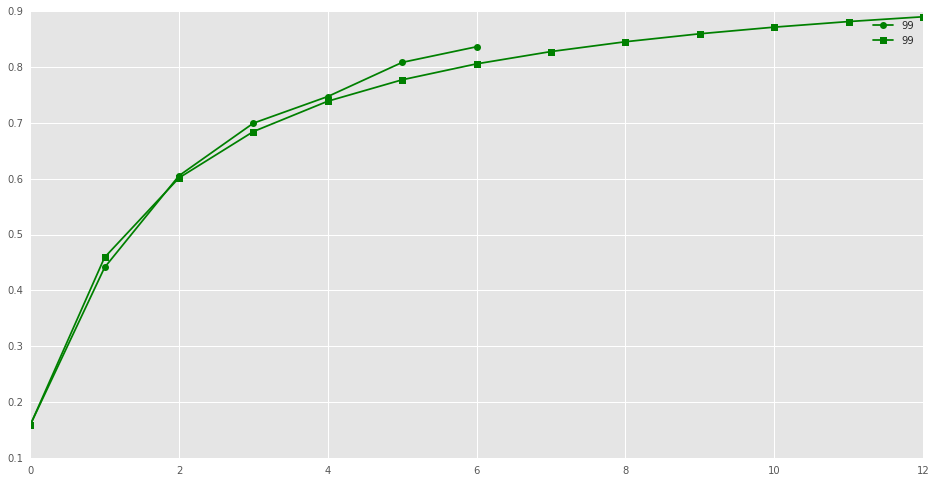

In [669]:
from sklearn.model_selection import train_test_split

data = df_data_1.loc[lambda df: df.subscription_monthly_cost == 99][['is_active','billing_cycles']]

train, test = train_test_split(data, test_size = 0.2)

sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=None,gamma=0.1,verbose=True)

# Train model
sbs.fit(data)
# Summary of results
print(sbs.summary())

pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])

f, axis = plt.subplots(1, 1, figsize=(16, 8))

axis.plot(df.loc[lambda df: (df.subscription_monthly_cost=='99')]['retention rate'].values[1:8], alpha=1, c=col_map['99'], label='99',marker='o')


inter_churn_gross = pred_test.mean().values[3:]
#print(inter_churn_gross)
inter_prop_active = 1-np.roll(np.cumsum(pred_test.mean().values[3:]),1)
inter_prop_active[0] = 1
int_retention = 1 - inter_churn_gross/inter_prop_active
axis.plot(int_retention, alpha=1, c=col_map['99'], label='99',marker="s")
    
plt.legend()

In [652]:
df_train = df_end.append(df,ignore_index=True)
df_train = df_train[lambda df: ((df.billing_cycles>0))]

X_train = pd.concat([df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]]*10000).values
Y_train = pd.concat([df_train['retention rate']]*10000).values

In [ ]:
from sklearn.neural_network import MLPRegressor
Model = MLPRegressor(hidden_layer_sizes=(5, ), activation='tanh', solver='adam', alpha=0.001,learning_rate = 'adaptive', learning_rate_init=0.001,max_iter=20000)
Model.fit(X_train,Y_train)

print(Model.predict(df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]))
print(df_train['retention rate'])

We want to start the insights by having some interactive plot of the data (on which you can see the values, select one line i.e. one country or one source)

In [649]:
import plotly
plotly.tools.set_credentials_file(username='CyrilleDS', api_key='0vitnGQBJrqhSjT0BNS6')

df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost','country','source'] ).size()}).reset_index()

df = df_data_overall.groupby(['subscription_monthly_cost','country','source','billing_cycles'] ).sum().groupby(level=[0,1,2]).cumsum()
df = df.add_suffix('_cumsum').reset_index()


user_count_per_country = df_data_1.groupby(['country']).count().reset_index()[['country','user_id']]
user_count_per_country = user_count_per_country.rename(columns={"user_id": "country_count"})

user_count_per_source = df_data_1.groupby(['source']).count().reset_index()[['source','user_id']]
user_count_per_source = user_count_per_source.rename(columns={"user_id": "source_count"})

def active_percent_country(characteristic):
    user_country = user_count_per_country[lambda df: df.country == characteristic].values[0,1]
    active_percent = (user_country - df_data_overall[lambda df: df.country == characteristic].groupby(['billing_cycles']).sum().cumsum()['count'])/user_country*100
    active_percent[0] = 100
    active_percent.sort_values(inplace=True,ascending=False)
    return active_percent

def active_percent_source(characteristic):
    user_source = user_count_per_source[lambda df: df.source == characteristic].values[0,1]
    active_percent = (user_source - df_data_overall[lambda df: df.source == characteristic].groupby(['billing_cycles']).sum().cumsum()['count'])/user_source*100
    active_percent[0] = 100
    active_percent.sort_values(inplace=True,ascending=False)
    return active_percent
    

In [650]:
import plotly.plotly as py
from plotly.graph_objs import *

billing_cycles = [0, 1, 2, 3, 4, 5, 6, 7]


trace1 = Scatter(x=billing_cycles, y=active_percent_country('Germany'),line=Line(color='#C0C0C0',width=3),name='Germany')

trace2 = Scatter(x=billing_cycles, y=active_percent_country('France'),line=Line(color='#FFD700',width=3),name='France')

trace3 = Scatter(x=billing_cycles, y=active_percent_country('UK'),line=Line(color='#C0C0C0',width=3),name='UK')

trace4 = Scatter(x=billing_cycles, y=active_percent_country('US'),line=Line(color='#228b22',width=3),name='US')

trace5 = Scatter(x=billing_cycles, y=active_percent_country('India'),line=Line(color='#d2691e',width=3),name='India')

trace6 = Scatter(x=billing_cycles, y=active_percent_country('Italy'),line=Line(color='#9400d3',width=3),name='Italy')

trace7 = Scatter(x=billing_cycles, y=active_percent_country('Spain'),line=Line(color='#ff0000',width=3),name='Spain')

trace8 = Scatter(x=billing_cycles, y=active_percent_country('China'),line=Line(color='#191970',width=3),name='China')

trace9 = Scatter(x=billing_cycles,y=active_percent_source('seo'),line=Line(color='#8b7d6b',width=3),name='seo')

trace10 = Scatter(x=billing_cycles, y=active_percent_source('ads'),line=Line(color='#BA8651',width=3),name='ads')

trace11 = Scatter(x=billing_cycles, y=active_percent_source('friend_referral'),line=Line(color='#000000',width=3),name='friend_referral')


data = Data([trace1, trace2, trace3, trace4,trace5, trace6, trace7, trace8,trace9, trace10, trace11])
layout = Layout(
    title='Cohort Analysis',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, True, True, True,True,True,True,True,False,False,False]],
                    label='Country',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False,False,False,False,False,True,True,True]],
                    label='Source',
                    method='restyle'
                ),

            ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [54]:
df = df_data_overall.groupby(['subscription_monthly_cost','billing_cycles'] ).sum().groupby(level=[0]).cumsum()
df = df.add_suffix('_cumsum').reset_index()
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
df = pd.merge(df, user_count, how='inner', on='subscription_monthly_cost')

In [55]:
df = df.rename(columns={"count_cumsum": "# churners"})

df['# active'] = df['user_count'] - df['# churners']

# Adding the month 0 to the dataframe

df_0 = pd.DataFrame({'billing_cycles': [0,0,0],'# churners': [0,0,0],'subscription_monthly_cost' : user_count['subscription_monthly_cost'],'# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

df = df_0.append(df,ignore_index=True)

# number of active subscribers normalized (%)

df['% active'] = df['# active']/df['user_count']*100

# churn rate 

df = df.sort_values(['subscription_monthly_cost','billing_cycles'])

df['churn rate'] = (df['# churners']-df['# churners'].shift(1))/df['# active'].shift(1)

# retention rate

df['retention rate'] = 1 - df['churn rate']

df = df.join(pd.get_dummies(df['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))


df_end = pd.DataFrame({'billing_cycles': [100,100,100],'retention rate' :[1,1,1],'subscription_monthly_cost':[29,49,99],'subscription_monthly_cost_29':[1,0,0],'subscription_monthly_cost_49':[0,1,0],'subscription_monthly_cost_99':[0,0,1]})
    



In [56]:
#print(df_end)
df_train = df_end.append(df,ignore_index=True)
#print(df.head())
    
#df_train = df_train[lambda df: ((df.billing_cycles>0) & (df.billing_cycles != 7))]
df_train = df_train[lambda df: ((df.billing_cycles>0))]

#df_train = df[lambda df: ((df.billing_cycles>0) & (df.billing_cycles < 7))]
X_train = pd.concat([df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]]*10000).values
Y_train = pd.concat([df_train['retention rate']]*10000).values

In [57]:
from sklearn.neural_network import MLPRegressor
Model = MLPRegressor(hidden_layer_sizes=(5, ), activation='tanh', solver='adam', alpha=0.001,learning_rate = 'adaptive', learning_rate_init=0.001,max_iter=20000)
Model.fit(X_train,Y_train)

print(Model.predict(df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]))
print(df_train['retention rate'])

[ 1.00042933  1.00042661  1.00042688  0.60672522  0.7570421   0.81979093
  0.85713282  0.8841623   0.9038143   0.9181692   0.38242153  0.54261841
  0.64620769  0.71848181  0.7679881   0.80205275  0.82661488  0.16022171
  0.44050814  0.60332097  0.70147643  0.76341464  0.80356187  0.83096489]
0     1.000000
1     1.000000
2     1.000000
4     0.607542
5     0.754636
6     0.820619
7     0.858588
8     0.883564
9     0.900991
10    0.917344
12    0.383666
13    0.537570
14    0.649913
15    0.719664
16    0.767858
17    0.802031
18    0.822201
20    0.158769
21    0.441145
22    0.605524
23    0.699734
24    0.747468
25    0.808637
26    0.836649
Name: retention rate, dtype: float64


In [62]:
#df_future = pd.DataFrame({'billing_cycles': [8, 9, 10, 11, 12, 8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
#                     'subscription_monthly_cost' : [29,29,29,29,29,49,49,49,49,49,99,99,99,99,99]})

df_future = pd.DataFrame({'billing_cycles': [8, 9, 10, 11, 12, 8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
                     'subscription_monthly_cost' : [29,29,29,29,29,49,49,49,49,49,99,99,99,99,99]})

df_predict = df_future.append(df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost','% active']],ignore_index=True)
df_predict = df_predict.join(pd.get_dummies(df_predict['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_')).sort_values(['subscription_monthly_cost','billing_cycles'])

df_predict['predicted retention rate'] = Model.predict(df_predict[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']])

df_predict = pd.merge(df_predict, df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost','retention rate']], how='left', on=['billing_cycles','subscription_monthly_cost'])
    #print(df_predict)

In [63]:
create_download_link(df_predict)

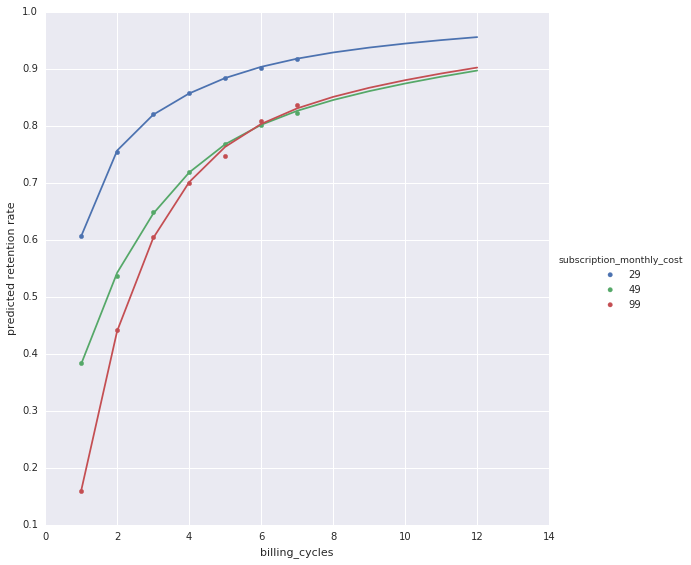

In [59]:
import seaborn as sns

#sns.lmplot('billing_cycles', 'count_cumsum', data=df, hue='subscription_monthly_cost', fit_reg=False, '-o')

g = sns.FacetGrid(df_predict, hue='subscription_monthly_cost', size=8)
g.map(plt.scatter, "billing_cycles", "retention rate")
#g.map(plt.plot, "billing_cycles", "retention rate").add_legend()
g.map(plt.plot, "billing_cycles", "predicted retention rate").add_legend()


plt.show()

In [225]:
output = pd.merge(df_predict[['billing_cycles','subscription_monthly_cost','predicted retention rate']],df[['billing_cycles','subscription_monthly_cost','retention rate','# active','# churners','user_count','% active','churn rate']],how='left',on=['billing_cycles','subscription_monthly_cost'])
output['predicted # active'] = output['# active']

for i in range(1, len(output)):
    if pd.isnull(output.ix[i, '# active']):
        output.ix[i, 'predicted # active'] = output.ix[i-1, 'predicted # active']*output.ix[i, 'predicted retention rate']
        output.ix[i,'user_count'] = output.ix[i-1,'user_count']
    else: 
        output.ix[i, 'predicted # active'] = output.ix[i, '# active']
        

output['predicted # churners'] = output['user_count'] - output['predicted # active']
output['predicted % active'] = output['predicted # active']/output['user_count']*100
output['predicted churn rate'] = 1-output['predicted retention rate']

output['revenue loss (k)'] = output['subscription_monthly_cost']*output['predicted # churners']/1000
output['revenue at risk this month (k)'] = (output['revenue loss (k)'] - output['revenue loss (k)'].shift(1))

for i in range(0, len(output)):
    if output.ix[i,'billing_cycles'] == 1:
        output.ix[i,'revenue at risk this month (k)'] = output.ix[i,'revenue loss (k)']

In [306]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost','country'] ).size()}).reset_index()
df = df_data_overall.groupby(['subscription_monthly_cost','country','billing_cycles'] ).sum().groupby(level=[0,1]).cumsum()
df = df.add_suffix('_cumsum').reset_index()
df = df[lambda df: df.billing_cycles == 7]
df['revenue loss since start (k)'] = df['count_cumsum']*df['subscription_monthly_cost']/1000
#print(df[lambda df: df.subscription_monthly_cost == 29])
Revenue_loss_per_country = df.groupby(['country']).sum().reset_index()

In [310]:
df

,subscription_monthly_cost,country,billing_cycles,count_cumsum,revenue loss since start (k)
6,29,China,7,6509,188.761
13,29,France,7,12364,358.556
20,29,Germany,7,19066,552.914
27,29,India,7,6674,193.546
34,29,Italy,7,11691,339.039
41,29,Spain,7,11133,322.857
48,29,UK,7,22054,639.566
55,29,US,7,22344,647.976
62,49,China,7,18159,889.791
69,49,France,7,30432,1491.168


In [313]:
!pip install adjustText

  Running setup.py bdist_wheel for adjustText ... done
  Stored in directory: /gpfs/fs01/user/s896-b5e1937eb03dc1-da7a39419701/.cache/pip/wheels/0a/70/31/c41e8cd4e9983778b0c570def9cfe1b904bb77b24b2144f54e
Successfully built adjustText


In [333]:
from adjustText import adjust_text

def plot_scatter(xy,label, alpha=0.25, figsize=(2,2), s=0.5, cmap='gist_rainbow',adjust=True):
    plt.figure(figsize=figsize, facecolor='white')
    plt.margins(0)
    #plt.axis('off')
    fig = plt.scatter(xy[:,0], xy[:,1],
                cmap=cmap, # set color map of markers
                alpha=alpha, # set alpha of markers
                marker=".", # use smallest available marker (square)
                s=s, # set marker size. single pixel is 0.5 on retina, 1.0 otherwise
                lw=0, # don't use edges
                edgecolor='') # don't use edges
    # remove all axes and whitespace / borders
    fig.axes.get_xaxis().set_visible(True)
    fig.axes.get_yaxis().set_visible(True)
    #for i, txt in enumerate(df_data_1.ix[:,4][0:100]):
        #plt.annotate(txt[0:100], (xy[i,0],xy[i,1]),xytext=(xy[i,0]+0.5, xy[i,1]+0.5),arrowprops=dict(arrowstyle="->"),size=10)
    texts = []
    for x, y, s in zip(xy[:,0], xy[:,1], label):
        texts.append(plt.text(x, y, s, size=15,color='black'))
    if adjust:
        plt.title(str(adjust_text(texts, arrowprops=dict(arrowstyle="-", color='b', lw=0.2)))+' iterations')
    #plt.colorbar()
    plt.show()

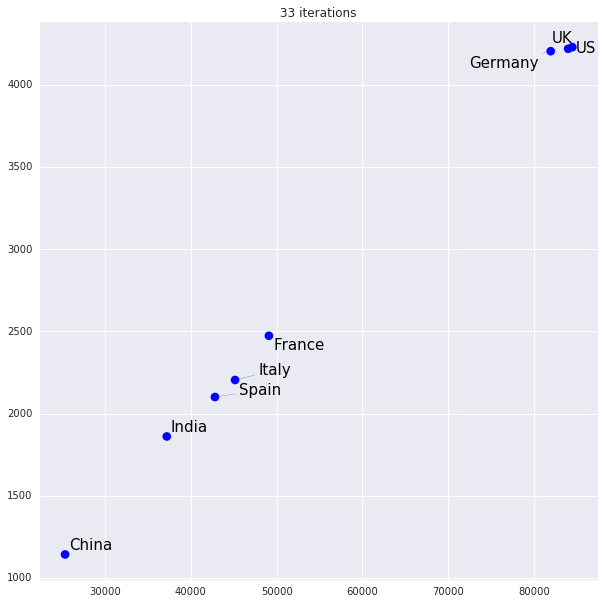

In [334]:
#fig, ax = plt.subplots()
#ax.scatter(Revenue_loss_per_country.ix[:,'count_cumsum'],Revenue_loss_per_country.ix[:,'revenue loss since start (k)'])

#for i, txt in enumerate(Revenue_loss_per_country.ix[:,'country']):
#    ax.annotate(txt, (Revenue_loss_per_country.ix[i,'count_cumsum'],Revenue_loss_per_country.ix[i,'revenue loss since start (k)']))


plot_scatter(Revenue_loss_per_country.ix[:,['count_cumsum','revenue loss since start (k)']].values,Revenue_loss_per_country.ix[:,'country'].values,alpha=3,figsize=(10,10), s = 300)

Bootstrap

In [40]:
predicted_bootstrap = np.zeros((500,2,12*3))

for i in range(0, 500):
    print(i)
    df_bootstrap = resample(df_data_1, n_samples=len(df_data_1))
    df = pd.DataFrame({'count' : df_bootstrap.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost'] ).size()}).reset_index()
    df = df.groupby(['subscription_monthly_cost','billing_cycles'] ).sum().groupby(level=[0]).cumsum()
    df = df.add_suffix('_cumsum').reset_index()
    user_count = pd.DataFrame({'user_count' : df_bootstrap.groupby(['subscription_monthly_cost']).size()}).reset_index()
    df = pd.merge(df, user_count, how='inner', on='subscription_monthly_cost')
    df = df.rename(columns={"count_cumsum": "# churners"})

    df['# active'] = df['user_count'] - df['# churners']

    # Adding the month 0 to the dataframe

    df_0 = pd.DataFrame({'billing_cycles': [0,0,0],'# churners': [0,0,0],'subscription_monthly_cost' : user_count['subscription_monthly_cost'],'# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

    df = df_0.append(df,ignore_index=True)

    # number of active subscribers normalized (%)

    df['% active'] = df['# active']/df['user_count']*100

    # churn rate 

    df = df.sort_values(['subscription_monthly_cost','billing_cycles'])

    df['churn rate'] = (df['# churners']-df['# churners'].shift(1))/df['# active'].shift(1)

    # retention rate

    df['retention rate'] = 1 - df['churn rate']

    df = df.join(pd.get_dummies(df['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))
    
    df_end = pd.DataFrame({'billing_cycles': [100,100,100],'retention rate' :[1,1,1],'subscription_monthly_cost':[29,49,99],'subscription_monthly_cost_29':[1,0,0],'subscription_monthly_cost_49':[0,1,0],'subscription_monthly_cost_99':[0,0,1]})
    
    #print(df_end)
    df_train = df_end.append(df,ignore_index=True)
    #print(df.head())
    
    #df_train = df_train[lambda df: ((df.billing_cycles>0) & (df.billing_cycles != 7))]
    df_train = df_train[lambda df: ((df.billing_cycles>0))]
    X_train = pd.concat([df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]]*20000).values
    Y_train = pd.concat([df_train['retention rate']]*20000).values
    
    from sklearn.neural_network import MLPRegressor
    Model = MLPRegressor(hidden_layer_sizes=(5, ), activation='tanh', solver='adam', alpha=0.001,learning_rate = 'constant', learning_rate_init=0.01,max_iter=40000)
    Model.fit(X_train,Y_train)
    
    df_future = pd.DataFrame({'billing_cycles': [8, 9, 10, 11, 12, 8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
                     'subscription_monthly_cost' : [29,29,29,29,29,49,49,49,49,49,99,99,99,99,99]})

    df_predict = df_future.append(df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost']],ignore_index=True)
    df_predict = df_predict.join(pd.get_dummies(df_predict['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_')).sort_values(['subscription_monthly_cost','billing_cycles'])

    df_predict['predicted retention rate'] = Model.predict(df_predict[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']])

    df_predict = pd.merge(df_predict, df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost','retention rate']], how='left', on=['billing_cycles','subscription_monthly_cost'])
    #print(df_predict)

    predicted_bootstrap[i,0,:] = df_predict['predicted retention rate']
    predicted_bootstrap[i,1,:] = df_predict['retention rate']
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [466]:
df = pd.DataFrame({'predicted_bootstrap': predicted_bootstrap[:,0,24:36].reshape(-1,), 'actual_bootstrap': predicted_bootstrap[:,1,24:36].reshape(-1,)}).reset_index()

df['billing_cycles'] = (df['index'] % 12) + 1

df['bootstrap'] = df['index'] // 12

#df_future = pd.DataFrame({'billing_cycles': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})
#predicted_bootstrap[0,0,0:12]

In [458]:
predicted_bootstrap[:,0,:].shape

(500, 36)

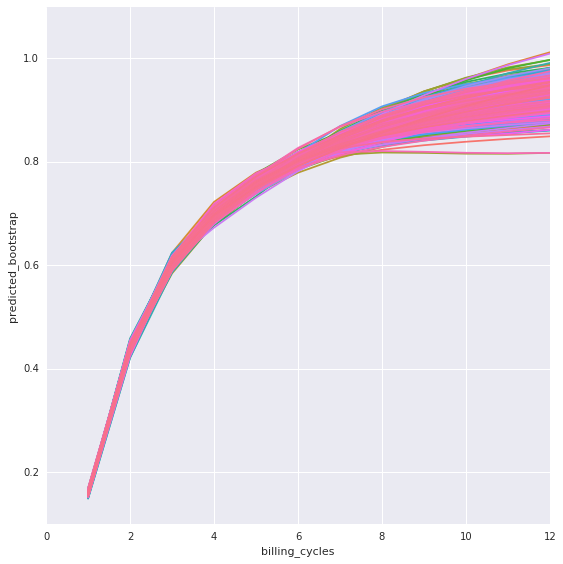

In [467]:
import seaborn as sns

#sns.lmplot('billing_cycles', 'count_cumsum', data=df, hue='subscription_monthly_cost', fit_reg=False, '-o')

g = sns.FacetGrid(df, hue='bootstrap', size=8)
#g.map(plt.scatter, "billing_cycles", "predicted_bootstrap")
g.map(plt.plot, "billing_cycles", "predicted_bootstrap")


plt.show()

In [476]:
l = round(0.025*len(predicted_bootstrap[:,0,0]))
h = round(0.975*len(predicted_bootstrap[:,0,0]))

lowerconfidence = df[df['billing_cycles']== 12].sort_values(['predicted_bootstrap']).reset_index().ix[l,'predicted_bootstrap']
higherconfidence = df[df['billing_cycles']== 12].sort_values(['predicted_bootstrap']).reset_index().ix[h,'predicted_bootstrap']

print(lowerconfidence)
print(higherconfidence)

0.873519778233
0.977319124545


In [155]:
df = df_data_overall.loc[lambda df: df.subscription_monthly_cost == 29].groupby('billing_cycles').sum().cumsum()
df = df.add_suffix('_cumsum').reset_index()

user_count = len(df_data_1.loc[lambda df: df.subscription_monthly_cost == 29].user_id.unique())

df['user_count'] = user_count
df = df.rename(columns={"count_cumsum": "# churners"})

df['# active'] = df['user_count'] - df['# churners']

# Adding the month 0 to the dataframe

df_0 = pd.DataFrame({'billing_cycles': [0],'# churners': [0],'# active': user_count , 'user_count' : user_count})

df = df_0.append(df,ignore_index=True)

# number of active subscribers normalized (%)

df['% active'] = df['# active']/df['user_count']*100

df['churn rate'] = (df['# churners']-df['# churners'].shift(1))/df['# active'].shift(1)

In [75]:
df

,# active,# churners,billing_cycles,subscription_monthly_cost_cumsum,user_count,% active
0,146362,0,0,NaN,146362,100.000000
1,88921,57441,1,696.0,146362,60.754157
2,67103,79259,2,1392.0,146362,45.847283
3,55066,91296,3,2088.0,146362,37.623154
4,47279,99083,4,2784.0,146362,32.302784
5,41774,104588,5,3480.0,146362,28.541561
6,37638,108724,6,4176.0,146362,25.715691
7,34527,111835,7,4872.0,146362,23.590140


In [557]:
from sklearn.model_selection import train_test_split


feature_list = ['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99']


# measured percentage of cohort that survives over time
data = df_data_1[['is_active','billing_cycles','subscription_monthly_cost']].join(pd.get_dummies(df_data_1['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))

data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')

train, test = train_test_split(data, test_size = 0.2)


sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=feature_list,gamma=1e-3,verbose=True)

# Train model
sbs.fit(data)
# Summary of results
print(sbs.summary())
    


Starting Optimization with parameters:
        Samples: 500000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:50   |  656516.10502 |

Optimization completed:
             wa: [ 0.20775421 -0.29736153  0.11967822  0.0558099 ]
             wb: [-0.13277891  0.05975989  0.0533784  -0.35219143]
  LogLikelihood: 656516.1050199613
   Reg. Penalty: 0.00023632079988174942

                               w_alpha    w_beta
bias                          0.207754 -0.132779
subscription_monthly_cost_29 -0.297362  0.059760
subscription_monthly_cost_49  0.119678  0.053378
subscription_monthly_cost_99  0.055810 -0.352191


In [583]:
pred_train = train.reset_index().join([sbs.predict_churn(train, age=1, n_periods=13)])
pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])

#pred_test.groupby('subscription_monthly_cost').mean().values[1,6:]-df.loc[lambda df: (df.subscription_monthly_cost==name) & (df.billing_cycles != 7) ]['churn rate gross'].values

In [595]:
#df.loc[lambda df: (df.subscription_monthly_cost==29) & (df.billing_cycles != 7)]['churn rate prop'].values
actual = df.loc[lambda df: (df.subscription_monthly_cost==29)]['churn rate prop'].values[1:8]

inter_churn_gross = pred_test.loc[lambda df: (df.subscription_monthly_cost=='29')].mean().values[7:14]
inter_prop_active = 1-np.roll(np.cumsum(pred_test.loc[lambda df: (df.subscription_monthly_cost=='29')].mean().values[7:14]),1)
inter_prop_active[0] = 1
int_churn_prop = inter_churn_gross/inter_prop_active


accuracy_29 = np.mean(1-np.abs(actual-int_churn_prop)/actual)

actual = df.loc[lambda df: (df.subscription_monthly_cost==49)]['churn rate prop'].values[1:8]

inter_churn_gross = pred_test.loc[lambda df: (df.subscription_monthly_cost=='49')].mean().values[7:14]
inter_prop_active = 1-np.roll(np.cumsum(pred_test.loc[lambda df: (df.subscription_monthly_cost=='49')].mean().values[7:14]),1)
inter_prop_active[0] = 1
int_churn_prop = inter_churn_gross/inter_prop_active


accuracy_49 = np.mean(1-np.abs(actual-int_churn_prop)/actual)

actual = df.loc[lambda df: (df.subscription_monthly_cost==99)]['churn rate prop'].values[1:8]

inter_churn_gross = pred_test.loc[lambda df: (df.subscription_monthly_cost=='99')].mean().values[7:14]
inter_prop_active = 1-np.roll(np.cumsum(pred_test.loc[lambda df: (df.subscription_monthly_cost=='99')].mean().values[7:14]),1)
inter_prop_active[0] = 1
int_churn_prop = inter_churn_gross/inter_prop_active


accuracy_99 = np.mean(1-np.abs(actual-int_churn_prop)/actual)


print(accuracy_29)
print(accuracy_49)
print(accuracy_99)

0.98912539766
0.969067332661
0.872378324477


In [437]:
from sklearn.model_selection import train_test_split

# measured percentage of cohort that survives over time
data = df_data_1.loc[lambda df: df.subscription_monthly_cost == 99][['is_active','billing_cycles']]

#data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')

train, test = train_test_split(data, test_size = 0.2)


sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=None,gamma=0.1,verbose=True)

# Train model
sbs.fit(data)
# Summary of results
print(sbs.summary())

Starting Optimization with parameters:
        Samples: 53241
  gamma (alpha): 0.1
   gamma (beta): 0.1
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:00   |   34889.05175 |

Optimization completed:
             wa: [ 0.41386031]
             wb: [-1.25706282]
  LogLikelihood: 34889.051746678895
   Reg. Penalty: 0.0

      w_alpha    w_beta
bias  0.41386 -1.257063


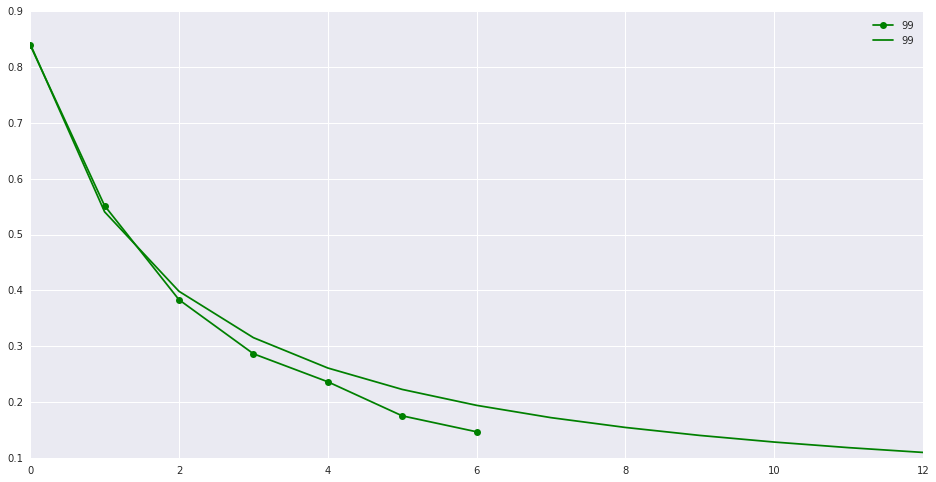

In [439]:
pred_train = train.reset_index().join([sbs.predict_churn(train, age=1, n_periods=13)])
pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])

f, axis = plt.subplots(1, 1, figsize=(16, 8))


axis.plot(df.loc[lambda df: (df.subscription_monthly_cost==99)]['churn rate prop'].values[1:8], alpha=1, c=col_map['99'], label='99',marker='o')


  #  print((df1.mean().values[7:]/(1-np.roll(np.cumsum(df1.mean().values[7:]),-1)))[1:])
inter_churn_gross = pred_test.mean().values[3:]
    #print(inter_churn_gross)
inter_prop_active = 1-np.roll(np.cumsum(pred_train.mean().values[3:]),1)
inter_prop_active[0] = 1
    #print(inter_prop_active)
int_churn_prop = inter_churn_gross/inter_prop_active
    #print(int_churn_prop)
axis.plot(int_churn_prop, alpha=1, c=col_map['99'], label='99',marker="_")
    
plt.legend()

In [604]:
predicted_bootstrap_alpha_beta = np.zeros((100000,3,13))

feature_list = ['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99']

for i in range(0, 5):
    print(i)
    df_bootstrap = resample(df_data_1, n_samples=len(df_data_1))



    # measured percentage of cohort that survives over time
    data = df_bootstrap[['is_active','billing_cycles','subscription_monthly_cost']].join(pd.get_dummies(df_data_1['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))

    data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')

    train, test = train_test_split(data, test_size = 0.2)


    sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=feature_list,gamma=1e-3,verbose=True)

    # Train model
    sbs.fit(data)
    
    
    pred_train = train.reset_index().join([sbs.predict_churn(train, age=1, n_periods=13)])
    pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])
    #print(pred_test.shape)
    
    #predicted_bootstrap_alpha_beta[i,0,:] = pred_train
    predicted_bootstrap_alpha_beta[i,0,:] = pred_test.groupby('subscription_monthly_cost').mean().values[0,6:]
    predicted_bootstrap_alpha_beta[i,1,:] = pred_test.groupby('subscription_monthly_cost').mean().values[1,6:]
    predicted_bootstrap_alpha_beta[i,2,:] = pred_test.groupby('subscription_monthly_cost').mean().values[2,6:]

0
Starting Optimization with parameters:
        Samples: 500000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:51   |  656105.65419 |

Optimization completed:
             wa: [ 0.20925438 -0.315001    0.10088712  0.04137472]
             wb: [-0.1317368   0.08355784  0.07574915 -0.34436336]
  LogLikelihood: 656105.6541894719
   Reg. Penalty: 0.00024242167979307794

1
Starting Optimization with parameters:
        Samples: 500000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:47   |  656361.80222 |

Optimization completed:
             wa: [ 0.19793765 -0.3048689   0.10818429  0.04047737]
             wb: [-0.14349267  0.1100709   0.10277385 -0.32878725]
  LogLikelihood: 656361.8022236206
   Reg. Penalty: 0.0002370664217304004

2
Starting Optimization with parameters:
        

In [606]:
predicted_bootstrap_alpha_beta[0:5,:,:]

array([[[  3.91487770e-01,   1.49430955e-01,   8.21249372e-02,
           5.30336312e-02,   3.75531565e-02,   2.82316885e-02,
           2.21361169e-02,   1.79071006e-02,   1.48393327e-02,
           1.25350920e-02,   1.07552581e-02,   9.34854716e-03,
           8.21518545e-03],
        [  6.19035306e-01,   1.70533091e-01,   7.37706759e-02,
           3.93715609e-02,   2.37894369e-02,   1.56112114e-02,
           1.08676574e-02,   7.90902155e-03,   5.95875807e-03,
           4.61594610e-03,   3.65821817e-03,   2.95496431e-03,
           2.42578089e-03],
        [  8.43710767e-01,   8.44923567e-02,   2.85560066e-02,
           1.36030983e-02,   7.71163222e-03,   4.86408853e-03,
           3.29875939e-03,   2.35803350e-03,   1.75431215e-03,
           1.34681128e-03,   1.06051589e-03,   8.52713878e-04,
           6.97751409e-04]],

       [[  3.92266562e-01,   1.49120367e-01,   8.18714432e-02,
           5.28552979e-02,   3.74263644e-02,   2.81391248e-02,
           2.20668235e-02,   1.7

In [487]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost','country','source'] ).size()}).reset_index()
#df_data_overall.head()

df = df_data_overall.groupby(['subscription_monthly_cost','country','source','billing_cycles'] ).sum().groupby(level=[0,1,2]).cumsum()
df = df.add_suffix('_cumsum').reset_index()

In [488]:
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country','source']).size()}).reset_index()
df = pd.merge(df, user_count, how='inner', on=['subscription_monthly_cost','country','source'])
df = df.rename(columns={"count_cumsum": "# churners"})

df['# active'] = df['user_count'] - df['# churners']

    # Adding the month 0 to the dataframe

df_0 = pd.DataFrame({'billing_cycles': np.zeros(72),'# churners': np.zeros(72),'subscription_monthly_cost' : user_count['subscription_monthly_cost'], 'country' : user_count['country'], 'source' : user_count['source'], '# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

df = df_0.append(df,ignore_index=True)

    # number of active subscribers normalized (%)

df['% active'] = df['# active']/df['user_count']*100

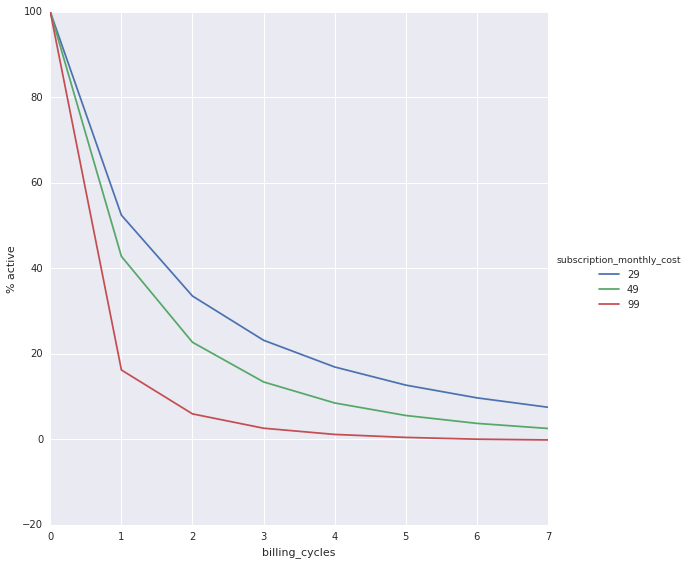

In [492]:
#axis.plot(df.loc[lambda df: df.country == ]['% active'], alpha=1, c=col_map[name], label=name,marker = "s")
g = sns.FacetGrid(df.loc[lambda df: (df.country == 'UK') & (df.source == 'ads')], hue='subscription_monthly_cost', size=8)
#g.map(plt.scatter, "billing_cycles", "predicted_bootstrap")
g.map(plt.plot, "billing_cycles", "% active").add_legend()


plt.show()

In [522]:
from mpl_toolkits.axes_grid1 import AxesGrid

#fig = plt.figure(1, (10, 10))
#grid = AxesGrid(fig, 111, nrows_ncols=(3, 1), axes_pad=0.1, cbar_mode = 'single')
sns.set(font_scale=5)

g = sns.FacetGrid(df, hue='subscription_monthly_cost', col='country',  row='source', size=20,xlim = [0,7],ylim = [0,100])
g.map(plt.scatter, "billing_cycles", "% active",s=800)
g.map(plt.plot, "billing_cycles", "% active",linewidth=8.0).add_legend()

#g = sns.FacetGrid(df.loc[lambda df: (df.country == 'UK') & (df.source == 'ads')], hue='subscription_monthly_cost', size=8)
#g.map(plt.scatter, "billing_cycles", "predicted_bootstrap")
#g.map(plt.plot, "billing_cycles", "% active").add_legend()

In [532]:
user_count_source = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country']).size()}).reset_index()
df_proportion_source = pd.merge(user_count, user_count_source, how='inner', on=['subscription_monthly_cost','country'])

In [535]:
df_proportion_source['user_count_prop'] = df_proportion_source['user_count_x']/df_proportion_source['user_count_y']
df_proportion_source

,subscription_monthly_cost,country,source,user_count_x,user_count_y,user_count_prop
0,29,China,ads,13611,16557,0.822069
1,29,China,friend_referral,809,16557,0.048862
2,29,China,seo,2137,16557,0.129069
3,29,France,ads,11924,14536,0.820308
4,29,France,friend_referral,755,14536,0.051940
5,29,France,seo,1857,14536,0.127752
6,29,Germany,ads,17911,21664,0.826763
7,29,Germany,friend_referral,1113,21664,0.051376
8,29,Germany,seo,2640,21664,0.121861
9,29,India,ads,14316,17137,0.835385


In [538]:
df_data_1.groupby(['subscription_monthly_cost']).size().reset_index()

,subscription_monthly_cost,0
0,29,146362
1,49,300397
2,99,53241


In [539]:
df_data_1.groupby(['country']).size().reset_index()

,country,0
0,China,35938
1,France,51662
2,Germany,88944
3,India,48027
4,Italy,47459
5,Spain,44987
6,UK,91252
7,US,91731


In [540]:
df_data_1.groupby(['source']).size().reset_index()

,source,0
0,ads,414469
1,friend_referral,24428
2,seo,61103


In [544]:
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country']).size()}).reset_index()
user_count_high = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
df_proportion_source = pd.merge(user_count_high, user_count, how='inner', on=['subscription_monthly_cost'])
df_proportion_source['user_count_prop'] = df_proportion_source['user_count_y']/df_proportion_source['user_count_x']
df_proportion_source

,subscription_monthly_cost,user_count_x,country,user_count_y,user_count_prop
0,29,146362,China,16741,0.114381
1,29,146362,France,14249,0.097355
2,29,146362,Germany,21794,0.148905
3,29,146362,India,16920,0.115604
4,29,146362,Italy,13336,0.091117
5,29,146362,Spain,12725,0.086942
6,29,146362,UK,25181,0.172046
7,29,146362,US,25416,0.173652
8,49,300397,China,18541,0.061722
9,49,300397,France,31074,0.103443


In [545]:
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country']).size()}).reset_index()
user_count_high = pd.DataFrame({'user_count' : df_data_1.groupby(['country']).size()}).reset_index()
df_proportion_source = pd.merge(user_count_high, user_count, how='inner', on=['country'])
df_proportion_source['user_count_prop'] = df_proportion_source['user_count_y']/df_proportion_source['user_count_x']
df_proportion_source

,country,user_count_x,subscription_monthly_cost,user_count_y,user_count_prop
0,China,35938,29,16741,0.465830
1,China,35938,49,18541,0.515916
2,China,35938,99,656,0.018254
3,France,51662,29,14249,0.275812
4,France,51662,49,31074,0.601487
5,France,51662,99,6339,0.122701
6,Germany,88944,29,21794,0.245031
7,Germany,88944,49,55500,0.623988
8,Germany,88944,99,11650,0.130981
9,India,48027,29,16920,0.352302


In [551]:
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['country','subscription_monthly_cost']).size()}).reset_index()
user_count_high = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
df_proportion_source = pd.merge(user_count_high, user_count, how='inner', on=['subscription_monthly_cost'])
df_proportion_source['user_count_prop'] = df_proportion_source['user_count_y']/df_proportion_source['user_count_x']
df_proportion_source

,subscription_monthly_cost,user_count_x,country,user_count_y,user_count_prop
0,29,146362,China,16741,0.114381
1,29,146362,France,14249,0.097355
2,29,146362,Germany,21794,0.148905
3,29,146362,India,16920,0.115604
4,29,146362,Italy,13336,0.091117
5,29,146362,Spain,12725,0.086942
6,29,146362,UK,25181,0.172046
7,29,146362,US,25416,0.173652
8,49,300397,China,18541,0.061722
9,49,300397,France,31074,0.103443


In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *

billing_cycles = [1, 2, 3, 4, 5, 6, 7]


#trace1 = Scatter(
#    x=countries, y=gold,
#    line=Line(
#        color='#FFD700',
#        width=3
#    ),
#    name='Gold'
#)

trace1 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'Germany'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Germany'
)


trace2 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'France'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='France'
)

trace3 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'UK'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='UK'
)


trace4 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'US'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#228b22',
        width=3
    ),
    name='US'
)

trace5 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'India'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#d2691e',
        width=3
    ),
    name='India'
)

trace6 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'Italy'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#9400d3',
        width=3
    ),
    name='Italy'
)

trace7 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'Spain'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#ff0000',
        width=3
    ),
    name='Spain'
)

trace8 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.country == 'China'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#191970',
        width=3
    ),
    name='China'
)

trace9 = Scatter(
    x=billing_cycles,
    y = df_data_overall[lambda df: df.source == 'seo'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#8b7d6b',
        width=3
    ),
    name='seo'
)


trace10 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.source == 'ads'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='ads'
)

trace11 = Scatter(
    x=billing_cycles, 
    y=df_data_overall[lambda df: df.source == 'friend_referral'].groupby(['billing_cycles']).sum().cumsum()['count'],
    line=Line(
        color='#000000',
        width=3
    ),
    name='friend_referral'
)




#trace3 = Scatter(
#    x=countries, y=bronze,
#    line=Line(
#        color='#BA8651',
#        width=3
#    ),
#    name='Bronze'
#)

#trace4 = Scatter(
#    x=countries, y=total,
#    line=Line(
#        color='#000000',
#        width=4
#    ),
#    name='Total'
#)

data = Data([trace1, trace2, trace3, trace4,trace5, trace6, trace7, trace8,trace9, trace10, trace11])
layout = Layout(
    title='Cumulative churn numbers',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, True, True, True,True,True,True,True,False,False,False]],
                    label='Country',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False,False,False,False,False,True,True,True]],
                    label='Source',
                    method='restyle'
                ),

            ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)